# Multiple sequence alignment

Import modules, including a function [`parse_pfam`](../../../data/msa/parse_pfam.py) in the `data_dir` that downloads the current release of the [Pfam database](https://pfam.xfam.org/), and stores the MSAs in that database on the local disk. Get a list of IDs from the [Protein Data Bank](https://www.rcsb.org/).

In [1]:
import fem
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches, colors
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import sys, os, time, pickle, pymol, Bio.PDB, warnings, nglview
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)
data_dir = '../../../data/msa'
sys.path.append(data_dir)
from parse_pfam import parse_pfam

Get a table `pfam` of information for all protein families in the Pfam database and a table `pdb_refs` of all references from sequences to PDB structures.

In [2]:
pfam, pdb_refs = parse_pfam(data_dir)
print 'total MSAs: %i, total PDB refs: %i' % (pfam.shape[0], pdb_refs.shape[0])

total MSAs: 16479, total PDB refs: 207746


Subset the Pfam table `pfam` to contain only the families that contain at least one sequence with a reference to a PDB structure.

In [3]:
pfam = pfam[pfam.index.isin(pdb_refs.index)]
print 'MSAs with PDB refs: %i' % (pfam.shape[0],)

MSAs with PDB refs: 5327


Each row in `pfam` contains information about a single protein family/multiple sequence alignment. Up until this point, the columns of `pfam` are `res`: the number of residues in each sequence of the alignment, `seq`: the number of sequences in the alignment. Now let's add a column `size=res*seq` and sort by that column to see which families contains the most data.

In [4]:
pfam['size'] = pfam['res']* pfam['seq']
pfam.sort_values(by='size', ascending=False, inplace=True)
pfam.head()

,res,seq,pdb_refs,size
PF00005,2386,369723,407,882159078
PF00069,3194,236455,3910,755237270
PF07690,3427,214283,23,734347841
PF00067,4853,85020,768,412602060
PF00501,3767,87704,145,330380968


Each row in the PDB references table `pdb_refs` contains information about a cross-reference between a protein family in the Pfam database and a protein structure in the PDB database. Up until this point, the columns of the table are `seq`: the index of a sequence in the protein family, `uniprot_id`: the ID of the sequence in the [UniProtKB](https://www.uniprot.org/help/uniprotkb) database, `uniprot_start`/`uniprot_end`: the start and end residue positions of the UniProtKB sequence that appears in the MSA, `pdb_id`: the PDB ID, `chain`: the PDB protein structure chain, `pdb_start`/`pdb_end`: the start and end residue positions of the PDB sequence that appears in the MSA. Let's create a column `res` that contains the length of the sequence and sort by that column.

In [5]:
pdb_refs['res'] = pdb_refs['pdb_end'] - pdb_refs['pdb_start'] + 1
pdb_refs.sort_values(by='res', ascending=False, inplace=True)
pdb_refs.head()

,seq,uniprot_id,uniprot_start,uniprot_end,pdb_id,chain,pdb_start,pdb_end,res
PF11894,578,NU205_HUMAN,14,1684,5IJN,J,14,1684,1671
PF11894,578,NU205_HUMAN,14,1684,5IJN,P,14,1684,1671
PF11894,578,NU205_HUMAN,14,1684,5IJN,D,14,1684,1671
PF11894,578,NU205_HUMAN,14,1684,5IJN,V,14,1684,1671
PF02463,2434,SMC1_YEAST,3,1213,1W1W,C,3,1213,1211


We'll examine the particular protein family with Pfam accesion code PF16592. This protein family corresponds to the REC lobe of CRISPR-associated endonuclease Cas9. The REC lobe and the NUC lobe of Cas9 fold to present a positively charged groove at their interface which accommodates the negatively charged sgRNA: target DNA heteroduplex. [[1]](https://www.ncbi.nlm.nih.gov/pubmed/24529477)

In [6]:
# Cas 9 family
ac = 'PF16592'
size_rank = pfam['size'].rank(ascending=False)[ac].astype(int)
print 'size rank: %i of %i' % (size_rank, pfam.shape[0])
pfam[pfam.index == ac]

size rank: 3734 of 5327


,res,seq,pdb_refs,size
PF16592,1079,146,21,157534


The MSA data for Pfam family with accession code PFXXXXX is stored on the local disk in the `Pfam-A.full/PFXXXXX` subdirectory of `data_dir` defined above. Here, we define a function for loading MSA data.

In [7]:
def get_msa(ac):
    fam_dir = os.path.join(data_dir, 'Pfam-A.full', ac)
    msa = np.load(os.path.join(fam_dir, 'msa.npy'))
    return msa

In [8]:
msa = get_msa(ac)
msa_int = fem.discrete.fit.categorize(msa)[0]
aa = np.array([np.unique(s) for s in msa])
one_aa = np.array([len(a) == 1 for a in aa])
two_aa = np.array([len(a) == 2 for a in aa])
missing_aa_res = np.array(['-' in a for a in aa])
conserved_residues = one_aa | (two_aa & missing_aa_res)
m = np.array([len(a) for a in aa])
m = m[~conserved_residues]
mm = np.insert(m.cumsum(), 0, 0)
print 'conserved residues: %i of %i' % (conserved_residues.sum(), msa.shape[0])

conserved residues: 225 of 1079


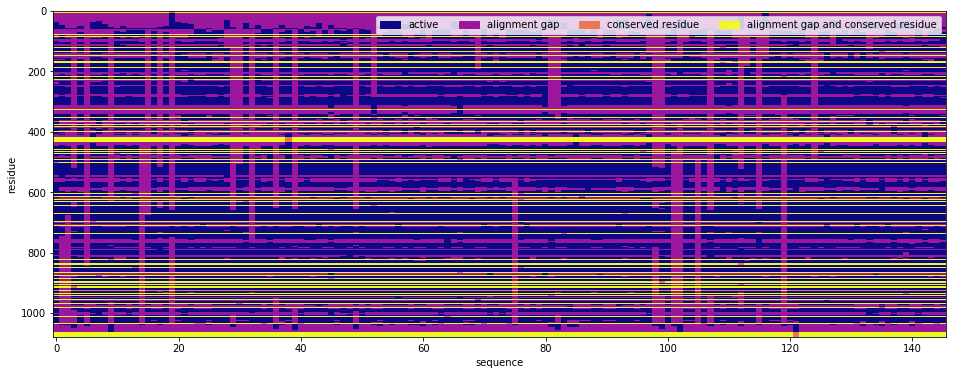

In [9]:
msa_code = np.zeros(msa.shape, dtype=int)
msa_code[conserved_residues] = 2
for j, s in enumerate(msa.T):
    msa_code[s == '-', j] += 1

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.set_xlabel('sequence')
ax.set_ylabel('residue')
cmap = plt.cm.get_cmap('plasma', 4)
ax.imshow(msa_code, aspect='auto', cmap=cmap)
labels = ['active', 'alignment gap', 'conserved residue', 'alignment gap and conserved residue']
handles = [patches.Patch(color=cmap(i), label=labels[i]) for i in range(4)]
plt.legend(handles=handles, ncol=4)
plt.show()

In [10]:
start = time.time()
w, d = fem.discrete.fit.fit(msa[~conserved_residues], degs=[1], iters=10)
# for i1, i2 in zip(mm[:-1], mm[1:]):
#     w[1][:, i1:i2] -= w[1][:, i1:i2].mean(1)[:,np.newaxis]
end = time.time()
print 'model fit time: %02f seconds' % (end-start,)

model fit time: 5.891613 seconds


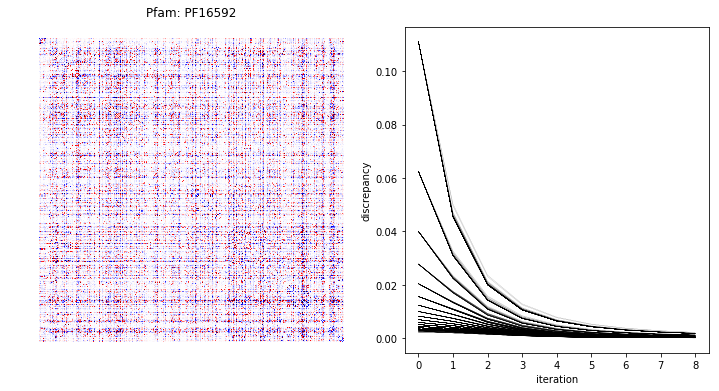

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
scale = 1e-1 * np.abs(w[1]).max()
ax[0].matshow(w[1], cmap=plt.cm.seismic, vmin=-scale, vmax=scale)
ax[0].axis('off')
ax[0].set_title('Pfam: %s' % (ac,))
for di in d:
    ax[1].plot(di, 'k-', lw=0.1)
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('discrepancy')
plt.show()

In [44]:
# di = np.zeros(())
# for i1, i2 in zip(mm[:-1], mm[1:]):
#     for j1, j2 in zip(mm[:-1], mm[1:]):
#         print np.exp(w[1][i1:i2, j1:j2])
msa.shape, mm.shape

((1079, 146), (855,))

In [12]:
refs = pdb_refs[pdb_refs.index.str.contains(ac)]
refs.head()

,seq,uniprot_id,uniprot_start,uniprot_end,pdb_id,chain,pdb_start,pdb_end,res
PF16592,70,CAS9_STRP1,181,712,4OO8,A,181,712,532
PF16592,70,CAS9_STRP1,181,712,4CMQ,A,181,712,532
PF16592,70,CAS9_STRP1,181,712,4OO8,D,181,712,532
PF16592,70,CAS9_STRP1,181,712,4ZT0,A,181,712,532
PF16592,70,CAS9_STRP1,181,712,5F9R,B,181,712,532


In [13]:
ref = refs.iloc[0]
seq = msa[:, ref.seq]
missing_aa_seq = seq == '-'
print 'PDB length == MSA seq length? %s' % (ref.res == seq[~missing_aa_seq].shape[0])
print 'aa sequence: %s' % (seq[~missing_aa_seq])

PDB length == MSA seq length? True
aa sequence: ['v' 'd' 'k' 'l' 'f' 'i' 'q' 'l' 'v' 'q' 't' 'y' 'n' 'q' 'l' 'f' 'e' 'e'
 'n' 'p' 'i' 'n' 'a' 's' 'g' 'v' 'd' 'a' 'k' 'a' 'i' 'l' 's' 'a' 'r' 'l'
 's' 'k' 's' 'r' 'r' 'l' 'e' 'n' 'l' 'i' 'a' 'q' 'l' 'p' 'g' 'e' 'k' 'k'
 'n' 'g' 'l' 'f' 'g' 'n' 'l' 'i' 'a' 'l' 's' 'l' 'g' 'l' 't' 'p' 'n' 'f'
 'k' 's' 'n' 'f' 'd' 'l' 'a' 'e' 'd' 'a' 'k' 'l' 'q' 'l' 's' 'k' 'd' 't'
 'y' 'd' 'd' 'd' 'l' 'd' 'n' 'l' 'l' 'a' 'q' 'i' 'g' 'd' 'q' 'y' 'a' 'd'
 'l' 'f' 'l' 'a' 'a' 'k' 'n' 'l' 's' 'd' 'a' 'i' 'l' 'l' 's' 'd' 'i' 'l'
 'r' 'v' 'n' 't' 'e' 'i' 't' 'k' 'a' 'p' 'l' 's' 'a' 's' 'm' 'i' 'k' 'r'
 'y' 'd' 'e' 'h' 'h' 'q' 'd' 'l' 't' 'l' 'l' 'k' 'a' 'l' 'v' 'r' 'q' 'q'
 'l' 'p' 'e' 'k' 'y' 'k' 'e' 'i' 'f' 'f' 'd' 'q' 's' 'k' 'n' 'g' 'y' 'a'
 'g' 'y' 'i' 'd' 'g' 'g' 'a' 's' 'q' 'e' 'e' 'f' 'y' 'k' 'f' 'i' 'k' 'p'
 'i' 'l' 'e' 'k' 'm' 'd' 'g' 't' 'e' 'e' 'l' 'l' 'v' 'k' 'l' 'n' 'r' 'e'
 'd' 'l' 'l' 'r' 'k' 'q' 'r' 't' 'f' 'd' 'n' 'g' 's' 'i' 'p' 'h' 'q' 'i'
 'h

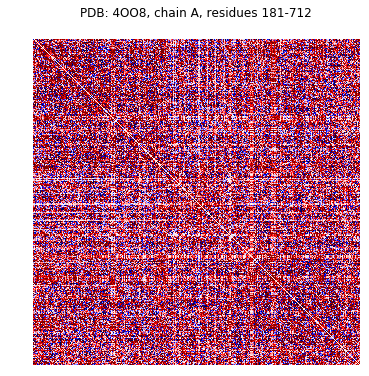

In [14]:
seq_int = msa_int[:, ref.seq]
seq_int = seq_int[~conserved_residues]
w_idx = mm[:-1] + seq_int
w_idx = w_idx[~missing_aa_seq[~conserved_residues]]
w_seq = w[1][np.ix_(w_idx, w_idx)]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
scale = 1e-1 * np.abs(w_seq).max()
ax.matshow(w_seq, cmap=plt.cm.seismic, vmin=-scale, vmax=scale)
ax.axis('off')
ax.set_title('PDB: %s, chain %s, residues %i-%i' % (ref.pdb_id, ref.chain, ref.pdb_start, ref.pdb_end))
plt.show()

Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4oo8.ent' 


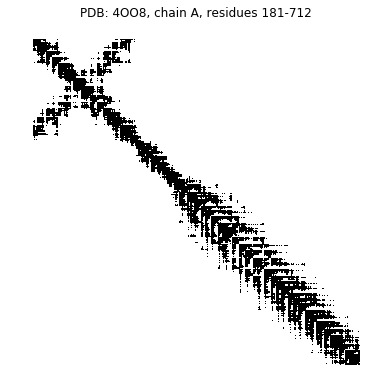

In [15]:
def get_contact_map(ref, dist_thresh=8):
    pdb_list = Bio.PDB.PDBList()
    pdb_parser = Bio.PDB.PDBParser()
    pdb_dir = os.path.join(data_dir, 'Pfam-A.full', ref.name)
    pdb_file = pdb_list.retrieve_pdb_file(ref.pdb_id, pdir=pdb_dir, file_format='pdb')
    chain = pdb_parser.get_structure(ref.pdb_id, pdb_file)[0][ref.chain]
    coords = np.array([a.get_coord() for a in chain.get_atoms()])
    coords = coords[ref.pdb_start-1:ref.pdb_end]
    coords = coords[~conserved_residues[~missing_aa_seq]]
    return distance_matrix(coords, coords) < dist_thresh

contact_map = get_contact_map(ref)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('PDB: %s, chain %s, residues %i-%i' % (ref.pdb_id, ref.chain, ref.pdb_start, ref.pdb_end))
ax.matshow(contact_map, cmap='Greys')
ax.axis('off')
plt.show()

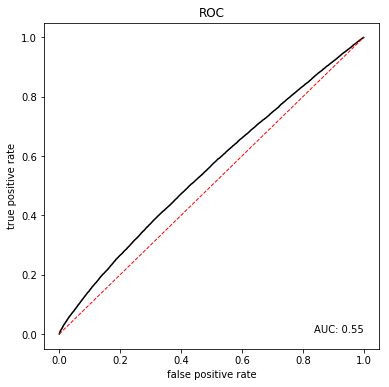

In [16]:
def roc(w, c):
    mask = ~np.eye(w.shape[0], dtype=bool)
    order = np.abs(w)[mask].argsort()[::-1]
    c_flat = c[mask][order]
    tp = np.cumsum(c_flat, dtype=float)
    fp = np.cumsum(~c_flat, dtype=float)
    tp /= tp[-1]
    fp /= fp[-1]
    return fp, tp

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fp, tp = roc(w_seq, contact_map)
ax.plot(fp, tp, 'k-')
grid = np.linspace(0, 1)
ax.plot(grid, grid, 'r--', lw=1)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('ROC')
ax.text(1, 0, 'AUC: %0.2f' % (tp.sum() / tp.shape[0],), va='bottom', ha='right')
plt.show()

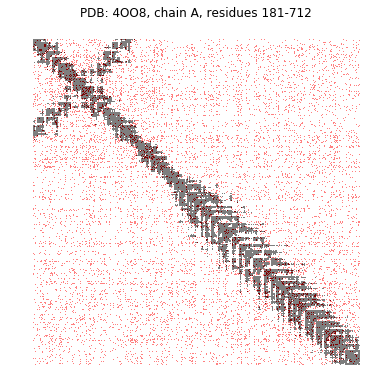

In [17]:
idx = contact_map.sum()
mask = ~np.eye(w_seq.shape[0], dtype=bool)
thresh = np.sort(np.abs(w_seq)[mask])[-idx]

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.matshow(contact_map, cmap='Greys')
cmap = colors.ListedColormap(['white', 'red'])
norm = colors.BoundaryNorm([0, 0.5, 1.0], 2)
ax.matshow((np.abs(w_seq) > thresh).astype(bool), cmap=cmap, norm=norm, alpha=0.5)
ax.axis('off')
ax.set_title('PDB: %s, chain %s, residues %i-%i' % (ref.pdb_id, ref.chain, ref.pdb_start, ref.pdb_end))
plt.show()

In [18]:
mask = ~np.eye(w_seq.shape[0], dtype=bool)
order = np.argsort(np.abs(w_seq)[mask])

res = np.arange(ref.pdb_start, ref.pdb_end+1)
res = res[~conserved_residues[~missing_aa_seq]]
mask = ~np.eye(res.shape[0], dtype=bool)
res_res = np.dstack(np.meshgrid(res, res)[::-1])[mask]

res_pairs = res_res[order[-100:]]

pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
pdb_dir = os.path.join(data_dir, 'Pfam-A.full', ref.name)
pdb_file = pdb_list.retrieve_pdb_file(ref.pdb_id, pdir=pdb_dir, file_format='pdb')
chain = pdb_parser.get_structure(ref.pdb_id, pdb_file)[0][ref.chain]
view = nglview.show_biopython(chain)
# view.clear_representations()
# view.add_licorice()
# view.add_surface(opacity=0.1)
# colors = ['0x0000FF'] * len(chain)
# view._set_color_by_residue(colors, component_index=0, repr_index=0)
view

Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4oo8.ent' 


NGLWidget()

Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4oo8.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4cmq.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4oo8.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4zt0.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5f9r.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4un4.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4zt0.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5fw2.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5b2t.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4un5.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4cmp.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4cmq.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5fw3.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5fq5.ent' 
Struct

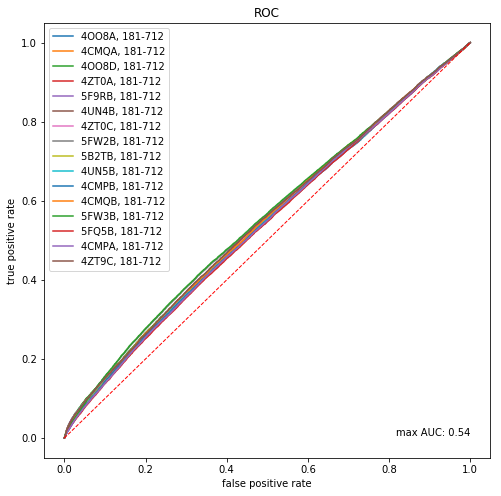

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

max_auc = 0

msa_int = fem.discrete.fit.categorize(msa)[0]
msa_oh = fem.discrete.fit.one_hot(msa_int[~conserved_residues], degs=[1])[0].todense()
tmp = np.cov(msa_oh)

for i in range(refs.shape[0]):
    ref = refs.iloc[i]
    seq = msa[:, ref.seq]
    missing_aa_seq = seq == '-'
    seq_int = msa_int[:, ref.seq][~conserved_residues]
    w_idx = (mm[:-1] + seq_int)[~missing_aa_seq[~conserved_residues]]
#     w_seq = w[1][np.ix_(w_idx, w_idx)]
    w_seq = tmp[np.ix_(w_idx, w_idx)]
    contact_map = get_contact_map(ref)
    fp, tp = roc(w_seq, contact_map)
    ax.plot(fp, tp, label='%s%s, %i-%i' % (ref.pdb_id, ref.chain, ref.pdb_start, ref.pdb_end))
    max_auc = max(max_auc, tp.sum() / tp.shape[0])

grid = np.linspace(0, 1)
ax.plot(grid, grid, 'r--', lw=1)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('ROC')
ax.text(1, 0, 'max AUC: %0.2f' % (max_auc,), va='bottom', ha='right')
plt.legend()
plt.show()

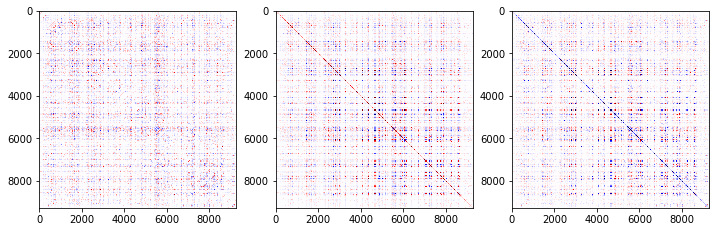

In [20]:
msa_int = fem.discrete.fit.categorize(msa[~conserved_residues])[0]
msa_oh = fem.discrete.fit.one_hot(msa_int, degs=[1])[0].todense()
tmp = np.cov(msa_oh)
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(w[1], cmap = 'seismic', vmin=-.1, vmax=.1)
ax[1].imshow(tmp, cmap = 'seismic', vmin=-.1, vmax=.1)
ax[2].imshow(w[1]-tmp, cmap = 'seismic', vmin=-.1, vmax=.1)
plt.show()

In [21]:
# # get 100 most extreme values of w[1]
# i = np.arange(w[1].shape[0])
# mask = ~np.eye(w[1].shape[0], dtype=bool)
# order = np.argsort(np.abs(w[1])[mask])
# ii = np.dstack(np.meshgrid(i, i)[::-1])[mask][order][::-1]
# mi = np.repeat(np.arange(mm.shape[0]-1), np.diff(mm))
# ij = set()
# index = 0
# while len(ij) < 100:
#     ij.add((mi[ii[index, 0]], mi[ii[index, 1]]))
#     index += 1

In [22]:
# from pymol import cmd

# def plot_pdb(pdb_id, chain, pdb_start, pdb_end):
#     return 0

# cmd.extend('plot_pdb', plot_pdb)


# ? pymol.cmd.extract
# fetch 'pdb_id'
# extract new_obj, resi pdb_start-pdb_end
# color slate, new_obj
# set cartoon_transparency, 0.5, 'pdb_id'
# color gray80, 'pdb_id'

In [23]:
# pdb_id = cas9_refs.iloc[i].pdb_id

In [24]:
# pymol.cmd.fetch(pdb_id, path='./')

In [25]:
# res_idx = np.argwhere(msa[:,0] != '-').squeeze()
# m_cumsum = np.insert(m.cumsum(), 0, 0)
# m1 = m_cumsum[:-1][res_idx]
# m2 = m_cumsum[1:][res_idx]
# v = np.empty((m2.max(), m2.max()))

# res1, res2, x = [], [], []
# for i, (i1, i2) in enumerate(zip(m1, m2)):
#     for j, (j1, j2) in enumerate(zip(m1, m2)):
#         res1.append(i)
#         res2.append(j)
#         x.append(np.abs(w[i1:i2, j1:j2]).sum())
        

# res1 = np.array(res1) + 130
# res2 = np.array(res2) + 130
# x = np.array(x)
# order = np.argsort(x)[::-1]

# res1 = res1[order]
# res2 = res2[order]
# x = x[order]

In [26]:
# print '5FQ5'
# for row in np.vstack((res1, res2, x)).T[:500]:
#     print int(row[0]), int(row[1]), row[2]

In [27]:
# dir(pymol)
# ? pymol.cmd.save

In [28]:
# pymol.cmd.set('grid_mode', 1)
# # gird_slot

In [29]:
# pymol.cmd.loadall(os.path.join(pf_dir, '*.cif'))

In [30]:
# pymol.cmd.png(filename = os.path.join(pf_dir, 'all.png'))
# pymol.cmd.save(filename = os.path.join(pf_dir, 'all.png'))

In [31]:
# def plot_pdb(pdbid, pf_dir):
#     pdbid = pdbid.lower()
#     pymol.cmd.fetch(pdbid, path=pf_dir)
#     pymol.cmd.load(filename = os.path.join(pf_dir, pdbid+'.cif'))
#     pymol.cmd.png(filename = os.path.join(pf_dir, pdbid+'.png'))

# pymol.cmd.extend('plot_pdb', plot_pdb)

# # for pdbid in pdbmap[pdbmap['pf'].str.contains('PF16592')].index:
# #     plot_pdb(pdbid, pf_dir)

In [32]:
# pymol -qcr <script.py>
# ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam31.0/

In [33]:
# import Bio
# from Bio import SeqIO
# msa = Bio.SeqIO.parse(os.path.join(data_dir, 'PF16592_ncbi.txt'), 'fasta')
# msa = np.array([np.array(s.seq) for s in msa]).T

In [34]:
# # random pdb
# pdb = pdbmap.sample()
# pfam = pf_info[pf_info.index.str.contains(pdb['pf'][0])]